# Final Project #
#### CSCI 4831 - Sabermetrics ####
#### Instructor: Rhonda Hoenigman ####
#### Name: Hussain Quadri ####

In [1]:
#Import Statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pybaseball import pitching_stats_range, pitching_stats_bref
from pybaseball import statcast
%matplotlib inline


## Data & Statistics

In [2]:
# Data grabbing
# data = statcast('2017-01-01', '2017-12-31')
pitchers = pd.read_csv("Statcast_Pitching_Data_2017.csv", low_memory=False)

In [3]:
pitchers.head(5)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,SL,2017-10-01,84.8,-1.7864,6.2820,George Kontos,645302,502004,strikeout,swinging_strike,...,8,11,8,11,11,8,8,11,Standard,Standard
1,SL,2017-10-01,85.5,-1.6885,6.2841,George Kontos,645302,502004,NaN,blocked_ball,...,8,11,8,11,11,8,8,11,Standard,Standard
2,SL,2017-10-01,85.5,-1.7503,6.3259,George Kontos,645302,502004,NaN,swinging_strike,...,8,11,8,11,11,8,8,11,Standard,Standard
3,FC,2017-10-01,89.1,-2.0060,6.2080,George Kontos,645302,502004,NaN,called_strike,...,8,11,8,11,11,8,8,11,Standard,Standard
4,FT,2017-10-01,95.3,1.8362,6.1102,Dan Runzler,457477,502130,single,hit_into_play_score,...,7,11,7,11,11,7,7,11,Standard,Standard


In [4]:
# Filter data for just bb_type, v(x,y,z)0/a(x,y,z) effective_speed, release_spin, launch_speed, and launch_speed_angle

filtered_data = pitchers[['player_name',
                 'pitcher',
                 'bb_type',
                 'vx0', 'vy0', 'vz0',
                 'ax', 'ay', 'az',
                 'effective_speed',
                 'release_spin_rate',
                 'launch_speed',
                 'launch_speed_angle']].groupby('player_name', as_index = False).mean()
filtered_data.head(10)

,player_name,pitcher,vx0,vy0,vz0,ax,ay,az,effective_speed,release_spin_rate,launch_speed,launch_speed_angle
0,A.J. Cole,595918,8.512532,-128.793136,-5.010755,-7.379529,26.317511,-18.617699,89.273396,2085.586667,83.557778,3.115385
1,A.J. Griffin,456167,7.315173,-111.576357,-1.819155,-4.818716,20.601927,-25.342316,76.914273,2303.795455,86.082353,2.923077
2,A.J. Minter,621345,-6.619438,-135.355933,-4.643859,2.231807,27.461484,-19.136134,92.728847,2435.559524,83.113636,3.666667
3,A.J. Schugel,519263,5.378207,-122.807768,-3.974014,-11.624157,24.676650,-24.567682,83.173500,2044.642857,93.120000,4.000000
4,AJ Ramos,573109,5.963688,-121.128854,-1.220308,-1.237573,25.911081,-28.563750,82.043615,2402.076923,77.583333,4.000000
5,Aaron Bummer,607481,-7.828298,-131.258252,-4.864595,7.926110,26.401634,-25.952766,89.881016,1879.032787,79.192308,2.625000
6,Aaron Loup,571901,-12.672285,-128.539391,-0.586739,14.616685,25.656235,-26.965228,87.930963,2191.185185,77.646154,3.000000
7,Aaron Nola,605400,4.695215,-124.797450,-0.936281,-1.493353,26.313115,-27.637181,86.061906,2212.509434,84.085000,3.000000
8,Aaron Slegers,642083,9.714577,-126.316347,-6.029173,-6.593954,26.660819,-19.384514,88.254700,1998.600000,80.247619,2.857143
9,Aaron Wilkerson,658792,4.833740,-122.527801,-3.197848,-0.606266,24.146006,-22.069269,84.521118,2233.141176,76.620000,2.777778


In [5]:
#Finding variance in variables to figure out weighting system

filtered_data.var()

# In this, we can see the most variance is in the release_spin_rate, and the least in launch_speed_angle
# Weighting will be done on a scale of 1-10, with 1 going to the variable with the highest variance, 
# and 10 going to the variable with the lowest variance

pitcher               5.329909e+09
vx0                   3.334922e+01
vy0                   2.178735e+01
vz0                   3.202052e+00
ax                    5.837049e+01
ay                    3.868383e+00
az                    1.772070e+01
effective_speed       1.148704e+01
release_spin_rate     3.417358e+04
launch_speed          2.409820e+01
launch_speed_angle    1.882984e-01
dtype: float64

In [6]:
# Weighted Statistic = PitchingQuality = ((10*launch_speed_angle + 9*vz0 + 8*ay + 7*effective_speed + 6*az
#                                            + 5*vy0 + 4*launch_speed + 3*vx0 + 2*ax + release_spin_rate)/(55*100))

filtered_data['Pitching_Quality'] = ((10*filtered_data['launch_speed_angle'] + 9*filtered_data['vz0'] + 8*filtered_data['ay'] 
                                      + 7*filtered_data['effective_speed'] + 6*filtered_data['az'] + 5*filtered_data['vy0'] 
                                      + 4*filtered_data['launch_speed'] + 3*filtered_data['vx0'] + 2*filtered_data['ax'] 
                                      + filtered_data['release_spin_rate'])/(55*100))

Updated_Data = filtered_data.sort_values(by=['Pitching_Quality'], ascending=False)
Updated_Data.head()

,player_name,pitcher,vx0,vy0,vz0,ax,ay,az,effective_speed,release_spin_rate,launch_speed,launch_speed_angle,Pitching_Quality
382,Nik Turley,543867,-6.823205,-129.752862,-3.777267,3.192990,26.276162,-23.091043,89.361952,2838.095238,86.980000,3.666667,0.586006
13,Adam Ottavino,493603,8.015969,-126.530474,-2.091300,3.283205,24.278650,-28.352014,87.398571,2740.785714,78.385714,3.250000,0.563977
193,Garrett Richards,572070,5.544795,-133.809761,-4.402649,-3.453745,28.273967,-27.164517,91.528934,2763.057851,76.300000,2.764706,0.563794
396,Phil Maton,664208,2.170637,-129.708775,-1.072506,-1.978343,27.058524,-23.291612,89.692196,2656.568627,77.683333,3.400000,0.554586
422,Ryan Pressly,519151,1.494685,-133.267561,-5.623546,0.842688,27.603324,-18.769815,91.179659,2608.097561,88.422222,3.500000,0.551358


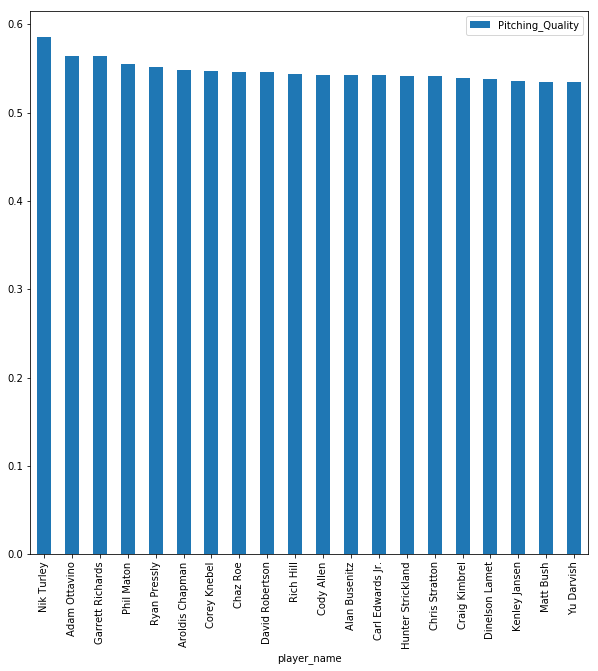

In [7]:
Updated_Data.head(20).plot.bar(x='player_name', y='Pitching_Quality', figsize=(10, 10))